# Read data

In [46]:
import logging
import pandas as pd
import numpy as np
from os import listdir
from os.path import basename, join

def excel2pandas(directory: str) -> pd.DataFrame:
    # format: oscuridad | papel | adhesivo | cubierta | color | medicion | valor 
    df_total = None
    
    for file in listdir(directory):
        if file.endswith(".xlsx"):
            try:
                name = basename(file)
                name = name.replace(".xlsx", "")

                chunks = name.split("_")

                df = None
                if len(chunks) == 4: # almacenada en oscuridad
                    df = process_oscuridad(join(directory, file))
                elif len(chunks) == 3: # almacenada normal
                    df = process_normal(join(directory, file))
                else: # format error
                    logging.warning(f"unknow format for file {file}")

                if df is not None:
                    if df_total is None:
                        df_total = df
                    else:
                        df_total = df_total.append(df)
            except Exception as e:
                logging.error(f"Error while processing file {file}, exception {e}")

    return df_total
        
def process_oscuridad(file: str) -> pd.DataFrame:
    name = basename(file)
    name = name.replace(".xlsx", "")
    
    chunks = name.split("_")
    
    cubierta = chunks[1]
    adhesivo = chunks[2]
    papel = chunks[3]
    
    df = pd.read_excel(file, header=None)
    
    rows = list(range(6,30))
    
    s = df.loc[1, :]
    hs = s.where(s == "L").dropna().index.tolist()
    column = hs[1] + 7
    
    h530 = df.loc[rows, [0,column]].rename(columns={0: "COLOR", column: "VALUE"}).reset_index()
    h530["PAPEL"] = papel
    h530["CUBIERTA"] = cubierta
    h530["ADHESIVO"] = adhesivo
    h530["MEDICION"] = "530h"
    h530["OSCURIDAD"] = True
    del h530["index"]
    
    return h530

def process_normal(file: str) -> pd.DataFrame:
    name = basename(file)
    name = name.replace(".xlsx", "")
    
    chunks = name.split("_")
    
    cubierta = chunks[0]
    adhesivo = chunks[1]
    papel = chunks[2]
    
    df = pd.read_excel(file, header=None)
    
    rows = list(range(6,30))
    
    s = df.loc[1, :]
    hs = s.where(s == "L").dropna().index.tolist()
    c265 = hs[1] + 7
    c530 = hs[2] + 7
    
    h265 = df.loc[rows, [0, c265]].rename(columns={0: "COLOR", c265: "VALUE"})
    h265["PAPEL"] = papel
    h265["CUBIERTA"] = cubierta
    h265["ADHESIVO"] = adhesivo
    h265["MEDICION"] = "265h"
    h265["OSCURIDAD"] = False
    
    h530 = df.loc[rows, [0, c530]].rename(columns={0: "COLOR", c530: "VALUE"})
    h530["PAPEL"] = papel
    h530["CUBIERTA"] = cubierta
    h530["ADHESIVO"] = adhesivo
    h530["MEDICION"] = "530h"
    h530["OSCURIDAD"] = False
    
    dfull = h265.append(h530).reset_index()
    del dfull["index"]
    
    return dfull

In [110]:
df = excel2pandas("data")

df.loc[df["ADHESIVO"] == "SILICONA CCC478-CAT CP48R", "ADHESIVO"] = "SILCIONA CCC478-CATCP48R"
df.loc[df["ADHESIVO"] == "SILICONA S160 NUEVA", "ADHESIVO"] = "SILICONA S160 I72T"
df.loc[df["PAPEL"] == "PAPEL HAHNEMUHLE", "PAPEL"] = "PAPEL HAHNEMÜHLE"

In [113]:
dfp = df[df["OSCURIDAD"] == False]
print(dfp.ADHESIVO.unique())
print(dfp.CUBIERTA.unique())
print(dfp.PAPEL.unique())

['SILCIONA CCC478-CATCP48R' 'CINTA JLAR' 'SUPER CEYS' 'CEYS SUPER UNIK'
 'SILICONA S160 I72T' 'CEYS CRISTAL' 'MACTAC']
['PMMA EXT' 'PMMA COLADA']
['PAPEL RC' 'PAPEL HAHNEMÜHLE' 'PAPEL DIATEC']


<AxesSubplot:xlabel='COLOR', ylabel='VALUE'>

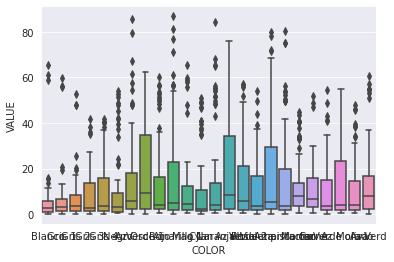

In [71]:
%matplotlib inline

import seaborn as sns
sns.set_style("darkgrid")

sns.boxplot(x="COLOR", y="VALUE", data=df)

# Configure colors 

In [65]:
df["COLOR"].unique()

array(['Blanco', 'Gris 1', 'Gris 2', 'Gris 3', 'Gris 4', 'Negro',
       'Az Osc', 'Verde 1', 'Rojo', 'Amarillo', 'Mag 1', 'Cyan',
       'Naranja', 'Az ult', 'Rosa', 'Violeta', 'Verde 2 pistacho',
       'Amarillo osc', 'Marron', 'Carne', 'Az', 'Verde oliva', 'Morado',
       'Az-Verd'], dtype=object)

In [72]:
order = ['Marron', 'Carne', 'Az', 'Verde oliva', 'Morado',
       'Az-Verd', 'Naranja', 'Az ult', 'Rosa', 'Violeta', 'Verde 2 pistacho',
       'Amarillo osc', 'Az Osc', 'Verde 1', 'Rojo', 'Amarillo', 'Mag 1', 'Cyan', 'Blanco', 'Gris 1', 'Gris 2', 'Gris 3', 'Gris 4', 'Negro']

In [115]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    return mpl.colors.to_hex((1-mix)*c1 + mix*c2)

n = 100

cmaps = {
    'Blanco': [colorFader("white","yellow",x/n) for x in range(n+1)],
    'Gris 1': [colorFader("lightgray","white",x/n) for x in range(n+1)],
    'Gris 2': [colorFader("darkgray","white",x/n) for x in range(n+1)],
    'Gris 3': [colorFader("gray","white",x/n) for x in range(n+1)],
    'Gris 4': [colorFader("dimgray","white",x/n) for x in range(n+1)],
    'Negro': [colorFader("black","white",x/n) for x in range(n+1)],
    'Az Osc': [colorFader("navy","white",x/n) for x in range(n+1)],
    'Verde 1': [colorFader("green","white",x/n) for x in range(n+1)],
    'Rojo': [colorFader("red","white",x/n) for x in range(n+1)],
    "Amarillo": [colorFader("yellow","white",x/n) for x in range(n+1)],
    "Mag 1": [colorFader("magenta","white",x/n) for x in range(n+1)],
    "Cyan": [colorFader("cyan","white",x/n) for x in range(n+1)],
    "Naranja": [colorFader("orange","white",x/n) for x in range(n+1)],
    "Az ult": [colorFader("royalblue","white",x/n) for x in range(n+1)],
    "Rosa": [colorFader("pink","white",x/n) for x in range(n+1)],
    "Violeta": [colorFader("blueviolet","white",x/n) for x in range(n+1)],
    "Verde 2 pistacho": [colorFader("yellowgreen","white",x/n) for x in range(n+1)],
    "Amarillo osc": [colorFader("darkkhaki","white",x/n) for x in range(n+1)],
    "Marron": [colorFader("sienna","white",x/n) for x in range(n+1)],
    "Carne": [colorFader("navajowhite","white",x/n) for x in range(n+1)],
    "Az": [colorFader("blue","white",x/n) for x in range(n+1)],
    "Verde oliva": [colorFader("darkolivegreen","white",x/n) for x in range(n+1)],
    "Morado": [colorFader("purple","white",x/n) for x in range(n+1)],
    "Az-Verd": [colorFader("aquamarine","white",x/n) for x in range(n+1)]
}

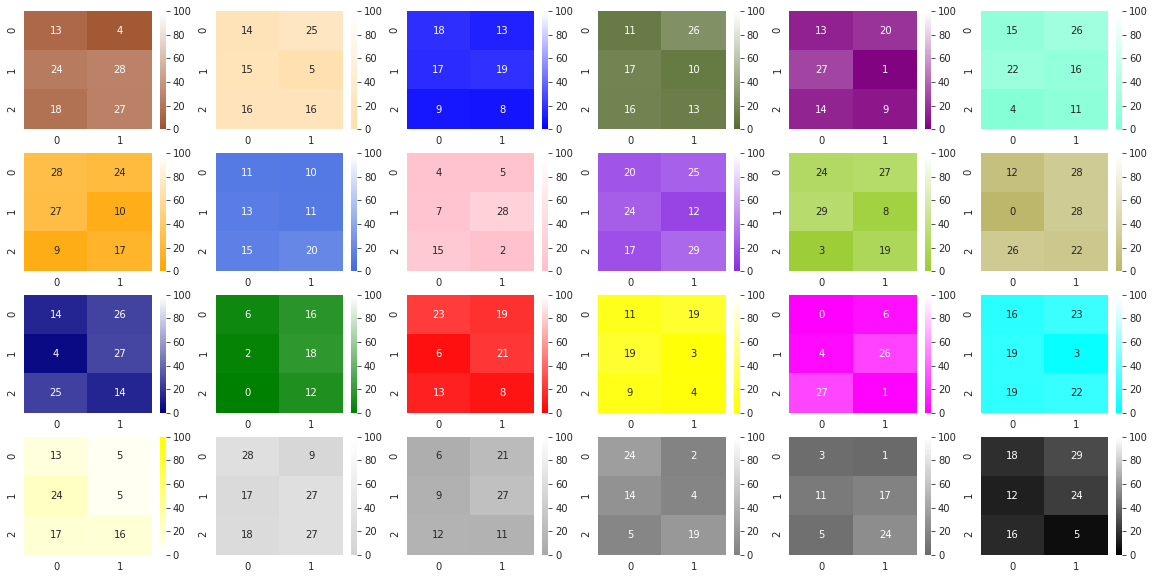

In [116]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

f, axs = plt.subplots(4, 6, figsize=(20, 10))

for i, c in enumerate(order):
    
    row = math.floor(i/6)
    col = i % 6
    
    data = np.random.randint(0, 30, 6).reshape(3,2)
    sns.heatmap(data, cmap=cmaps[c], ax=axs[row][col], vmin=0, vmax=100, annot=True)

# Draw graphics

In [199]:
import math
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

plt.rcParams.update({'font.size': 11})

def plot_2A4(name: str, data: pd.DataFrame):
    
    def plotA4(figname:str, colors: List[str]):
        f, axs = plt.subplots(4, 3, figsize=(w, h), sharex=True, sharey=True)
    
        for i, c in enumerate(colors):

            row = math.floor(i/3)
            col = i % 3
            
            dfp = data.query("COLOR == @c")
            dfp = dfp.loc[:, ["PAPEL", "ADHESIVO", "VALUE"]]
            dfp = dfp.pivot(index="PAPEL", columns="ADHESIVO", values="VALUE").astype(float)

            sns.heatmap(data=dfp, cmap=cmaps[c], ax=axs[row][col], vmin=0, vmax=100, annot=True, linewidths=0.1)
            axs[row][col].xaxis.label.set_visible(False)
            axs[row][col].yaxis.label.set_visible(False)

        plt.tight_layout()
        plt.savefig(figname, pad_inches=0.5)
        
    
    # split data into two A4
    a = np.array(order).reshape(4, 6)
    a1 = a[:, 0:3].flatten()
    a2 = a[:, 3:].flatten()
    
    # A4 size
    # h = 8.27
    # w = 11.69
    h = 11.69
    w = 8.27
    
    # plot the two A4
    plotA4(name + "_1.pdf", a1)
    plotA4(name + "_2.pdf", a2)

In [162]:
siliconas = ['SILCIONA CCC478-CATCP48R', 'SILICONA S160 I72T', 'MACTAC']
ceys = ['CINTA JLAR', 'CEYS SUPER UNIK', 'CEYS CRISTAL']

## Con oscuridad

### Siliconas

#### PMMA COLADA

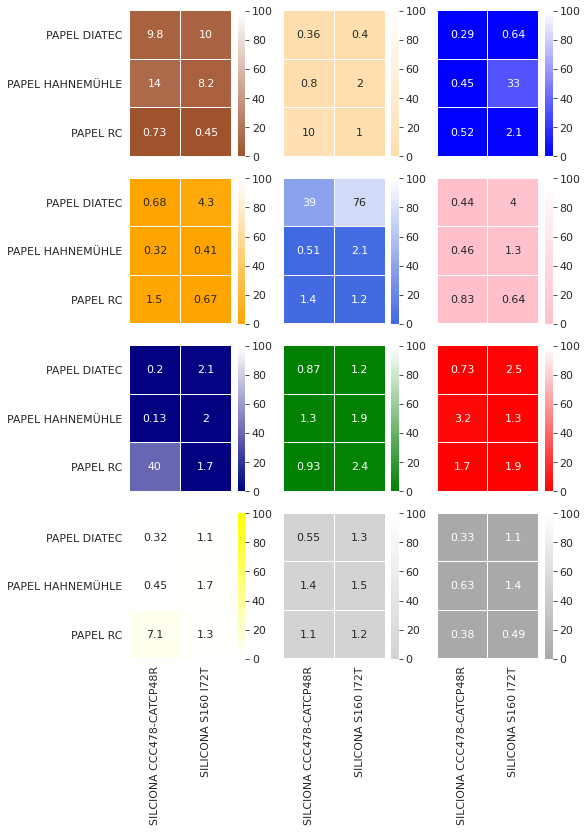

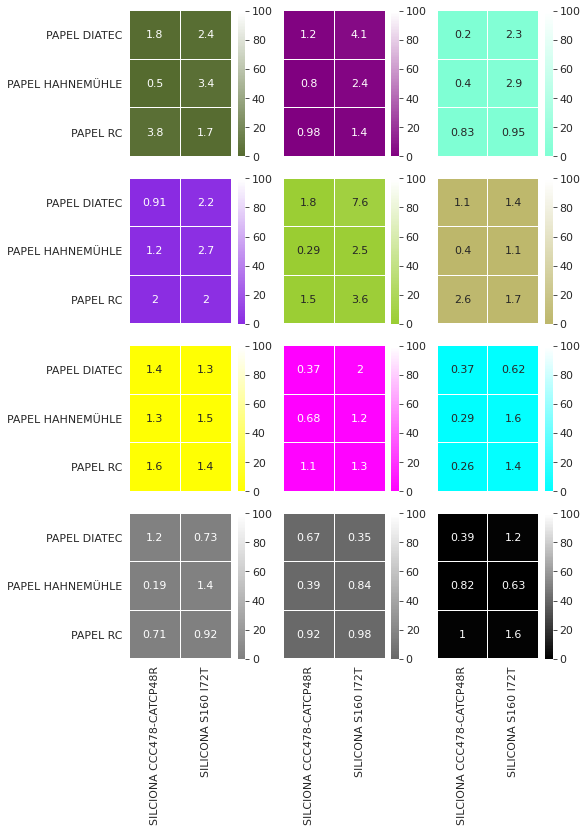

In [200]:
dfp = df.query("OSCURIDAD == True & CUBIERTA == 'PMMA COLADA' & MEDICION == '530h' & ADHESIVO in @siliconas")
plot_2A4("figures/EN-OSCURIDAD_SILICONAS_PMMA_COLADA", dfp)

#### PMMA EXT

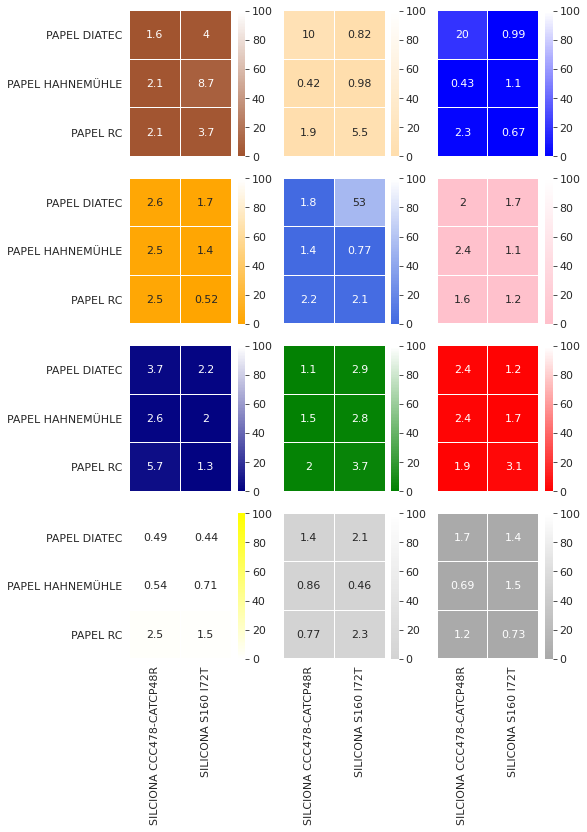

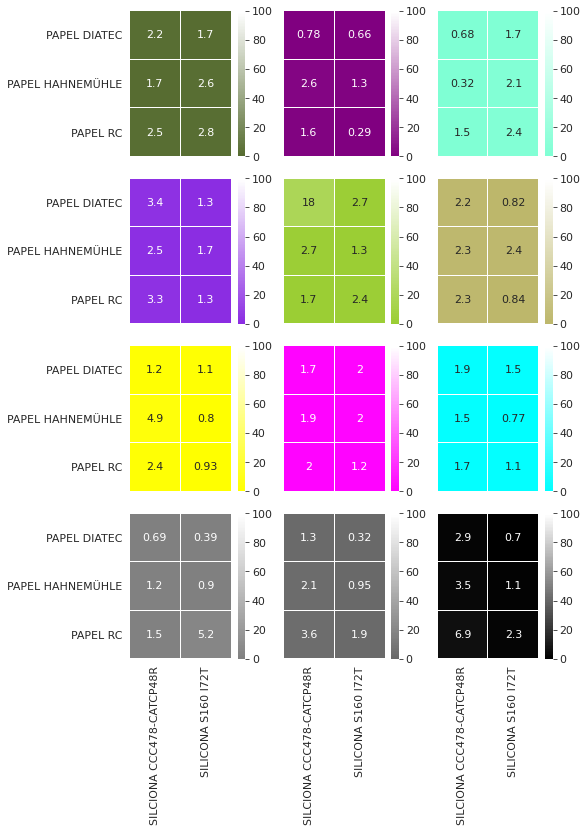

In [201]:
dfp = df.query("OSCURIDAD == True & CUBIERTA == 'PMMA EXT' & MEDICION == '530h' & ADHESIVO in @siliconas")
plot_2A4("figures/EN-OSCURIDAD_SILICONAS_PMMA EXT", dfp)

### Ceys

#### PMMA COLADA

/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data

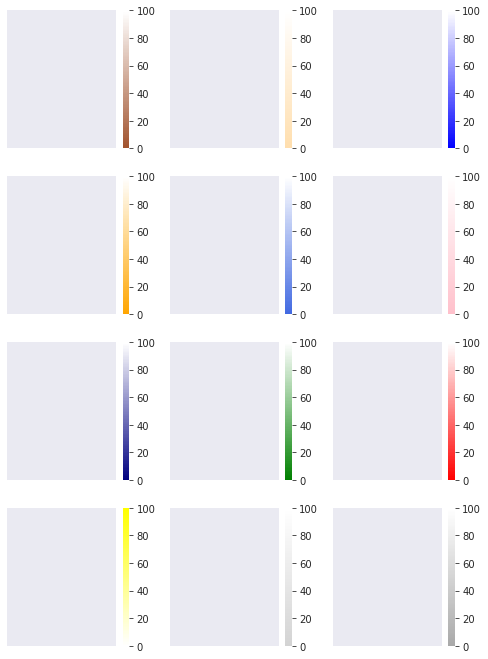

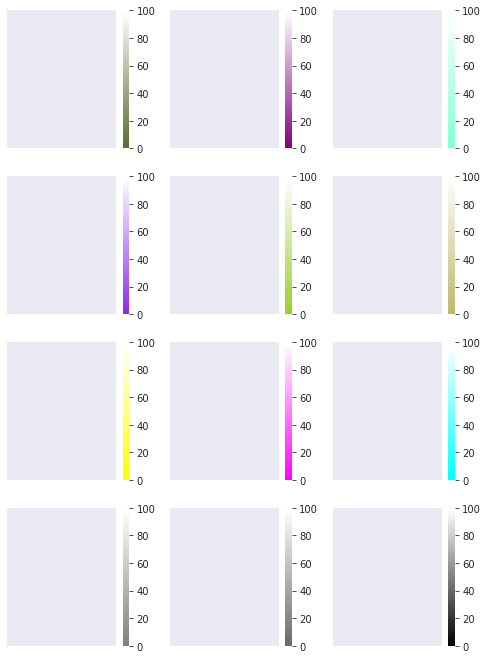

In [165]:
dfp = df.query("OSCURIDAD == True & CUBIERTA == 'PMMA COLADA' & MEDICION == '530h' & ADHESIVO in @ceys")
plot_2A4("figures/EN-OSCURIDAD_CEYS_PMMA_COLADA", dfp)

#### PMMA EXT

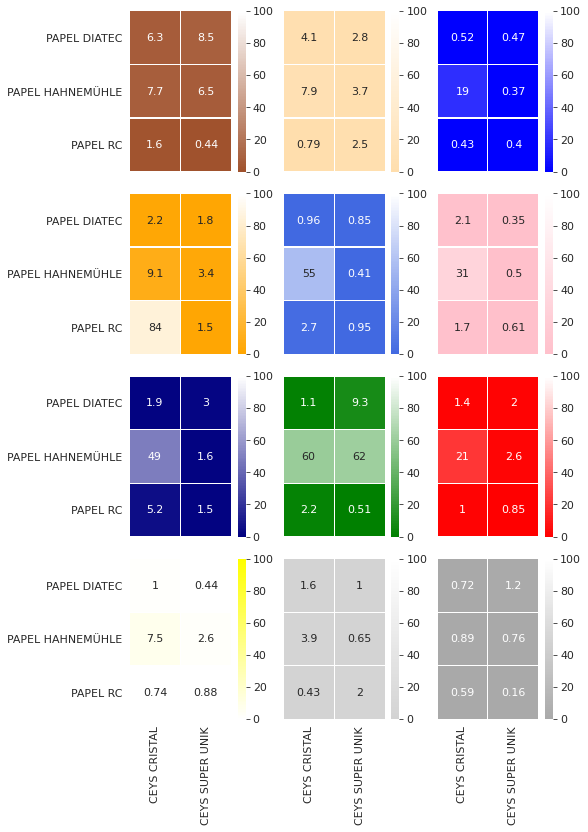

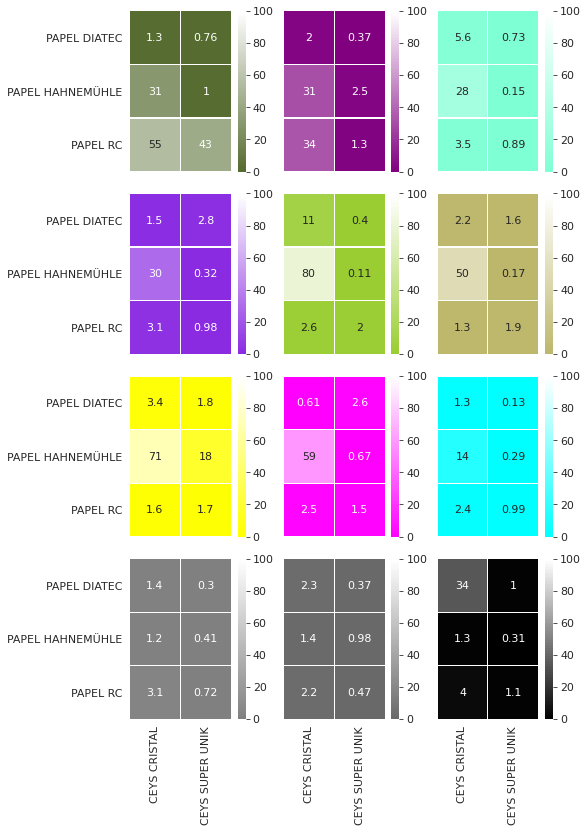

In [202]:
dfp = df.query("OSCURIDAD == True & CUBIERTA == 'PMMA EXT' & MEDICION == '530h' & ADHESIVO in @ceys")
plot_2A4("figures/EN-OSCURIDAD_CEYS_PMMA EXT", dfp)

## Sin oscuridad

### Siliconas

#### PMMA COLADA

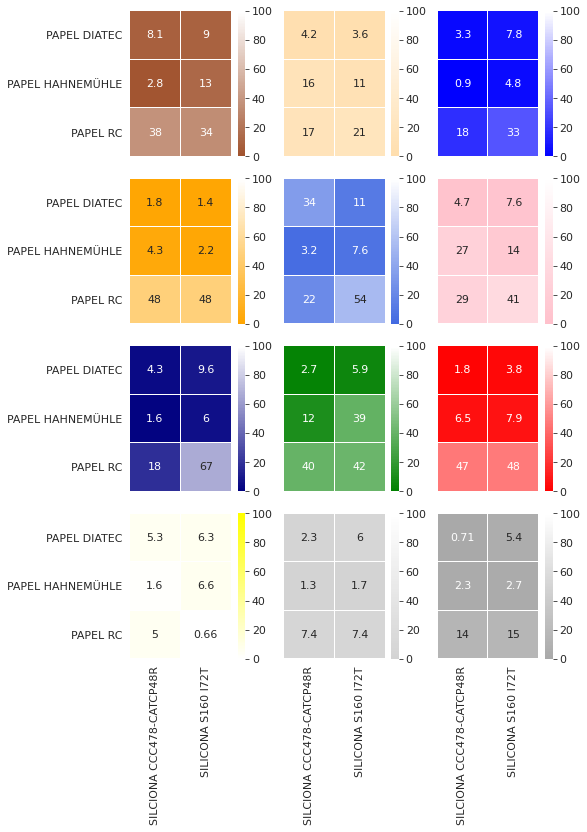

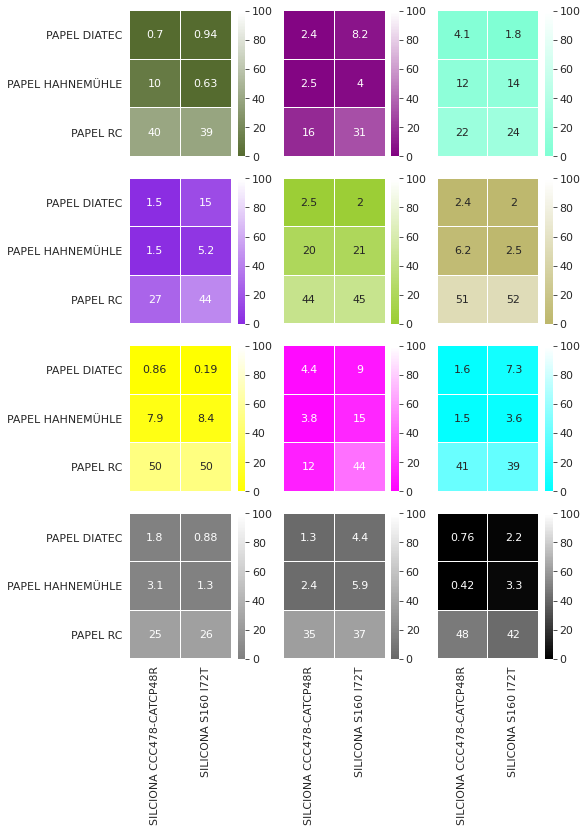

In [203]:
dfp = df.query("OSCURIDAD == False & CUBIERTA == 'PMMA COLADA' & MEDICION == '530h' & ADHESIVO in @siliconas")
plot_2A4("figures/SIN-OSCURIDAD_SILICONAS_PMMA_COLADA", dfp)

#### PMMA EXT

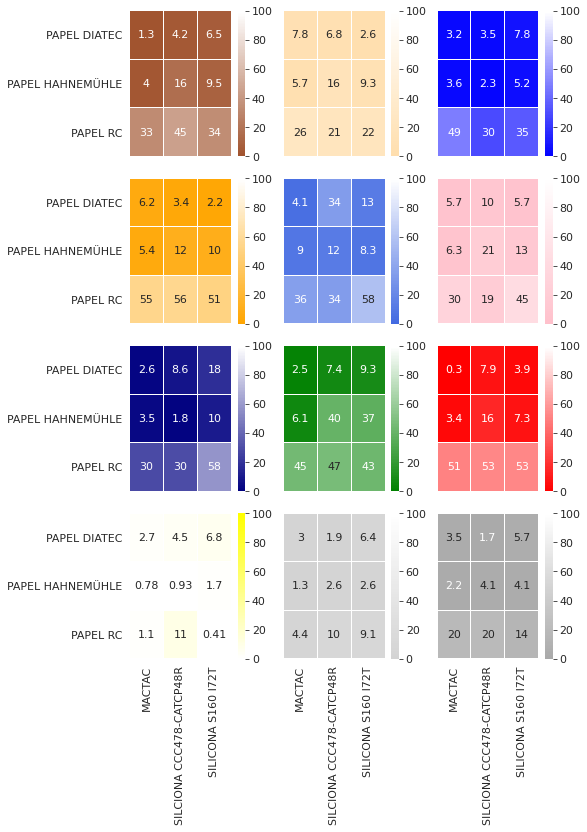

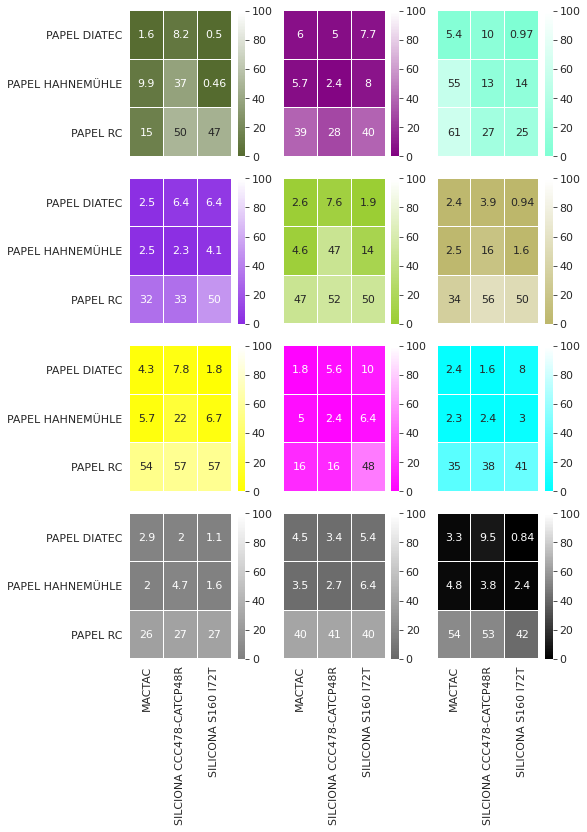

In [204]:
dfp = df.query("OSCURIDAD == False & CUBIERTA == 'PMMA EXT' & MEDICION == '530h' & ADHESIVO in @siliconas")
plot_2A4("figures/SIN-OSCURIDAD_SILICONAS_PMMA EXT", dfp)

### Ceys

#### PMMA COLADA

/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.7/site-packages/seaborn/matrix.py:305: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data

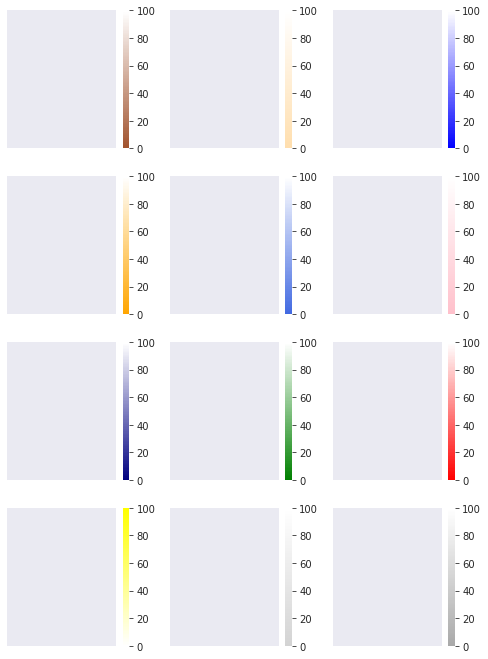

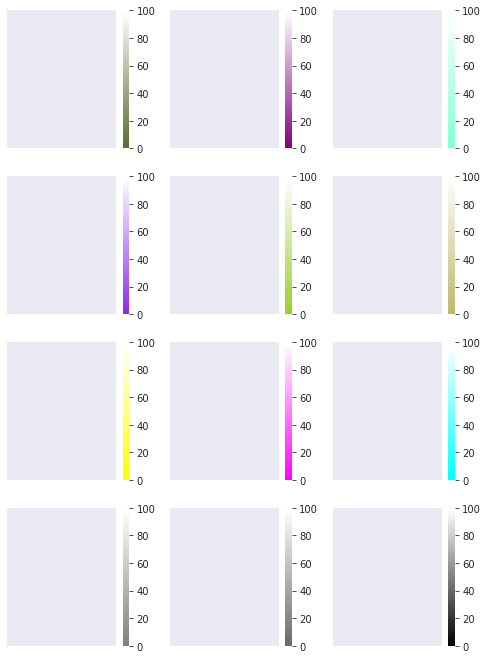

In [171]:
dfp = df.query("OSCURIDAD == False & CUBIERTA == 'PMMA COLADA' & MEDICION == '530h' & ADHESIVO in @ceys")
plot_2A4("figures/SIN-OSCURIDAD_CEYS_PMMA_COLADA", dfp)

#### PMMA EXT

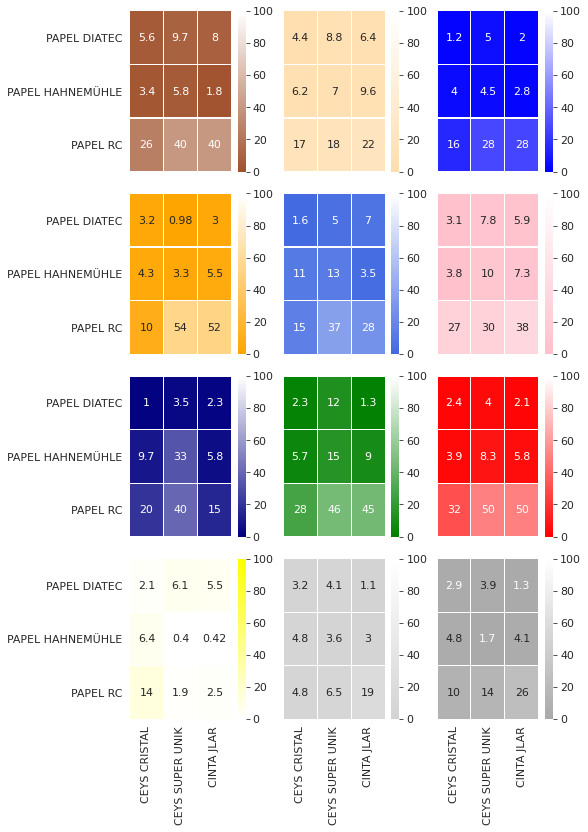

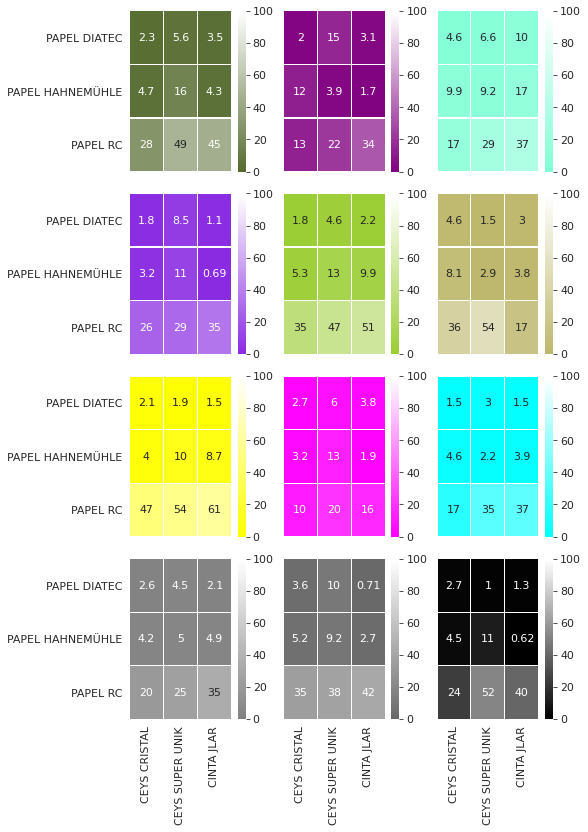

In [205]:
dfp = df.query("OSCURIDAD == False & CUBIERTA == 'PMMA EXT' & MEDICION == '530h' & ADHESIVO in @ceys")
plot_2A4("figures/SIN-OSCURIDAD_CEYS_PMMA EXT", dfp)